In [42]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from scipy import stats

from itry5 import CustomKinematicNet, FakeParticleDataset, worker_init_fn, batchsize, activation, hidden_layers, dfpath, modelsavepath

In [43]:
test_dataset= FakeParticleDataset()
test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=True, num_workers=4, worker_init_fn=worker_init_fn)
input_dim,output_dim=4,4
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = CustomKinematicNet(input_dim, hidden_layers, output_dim, activation_fn=activation)
model.load_state_dict(torch.load(modelsavepath))
model.to(device)

print("hidden_layers: ", hidden_layers)
print("activation: ", activation)
print("dfpath: ", dfpath)
print("modelsavepath: ", modelsavepath)




hidden_layers:  [12, 12, 12, 12, 12, 12, 12, 12, 12, 12]
activation:  <function leaky_relu at 0x7fa2d3e39040>
dfpath:  /home/ddemler/HNLclassifier/saved_files/fnn_featregr/single_particle/inv_itry5_losses.csv
modelsavepath:  /home/ddemler/HNLclassifier/saved_files/saved_models/FNN_FeatureRegression/Single_particle/inv_itry5_model.pt


In [44]:
for name, module in model.named_modules():
    if isinstance(module, nn.PReLU):
        alpha = module.weight.item()
        print(f"Alpha for PReLU layer {name}: {alpha}")

(300000, 4)
(300000, 4)


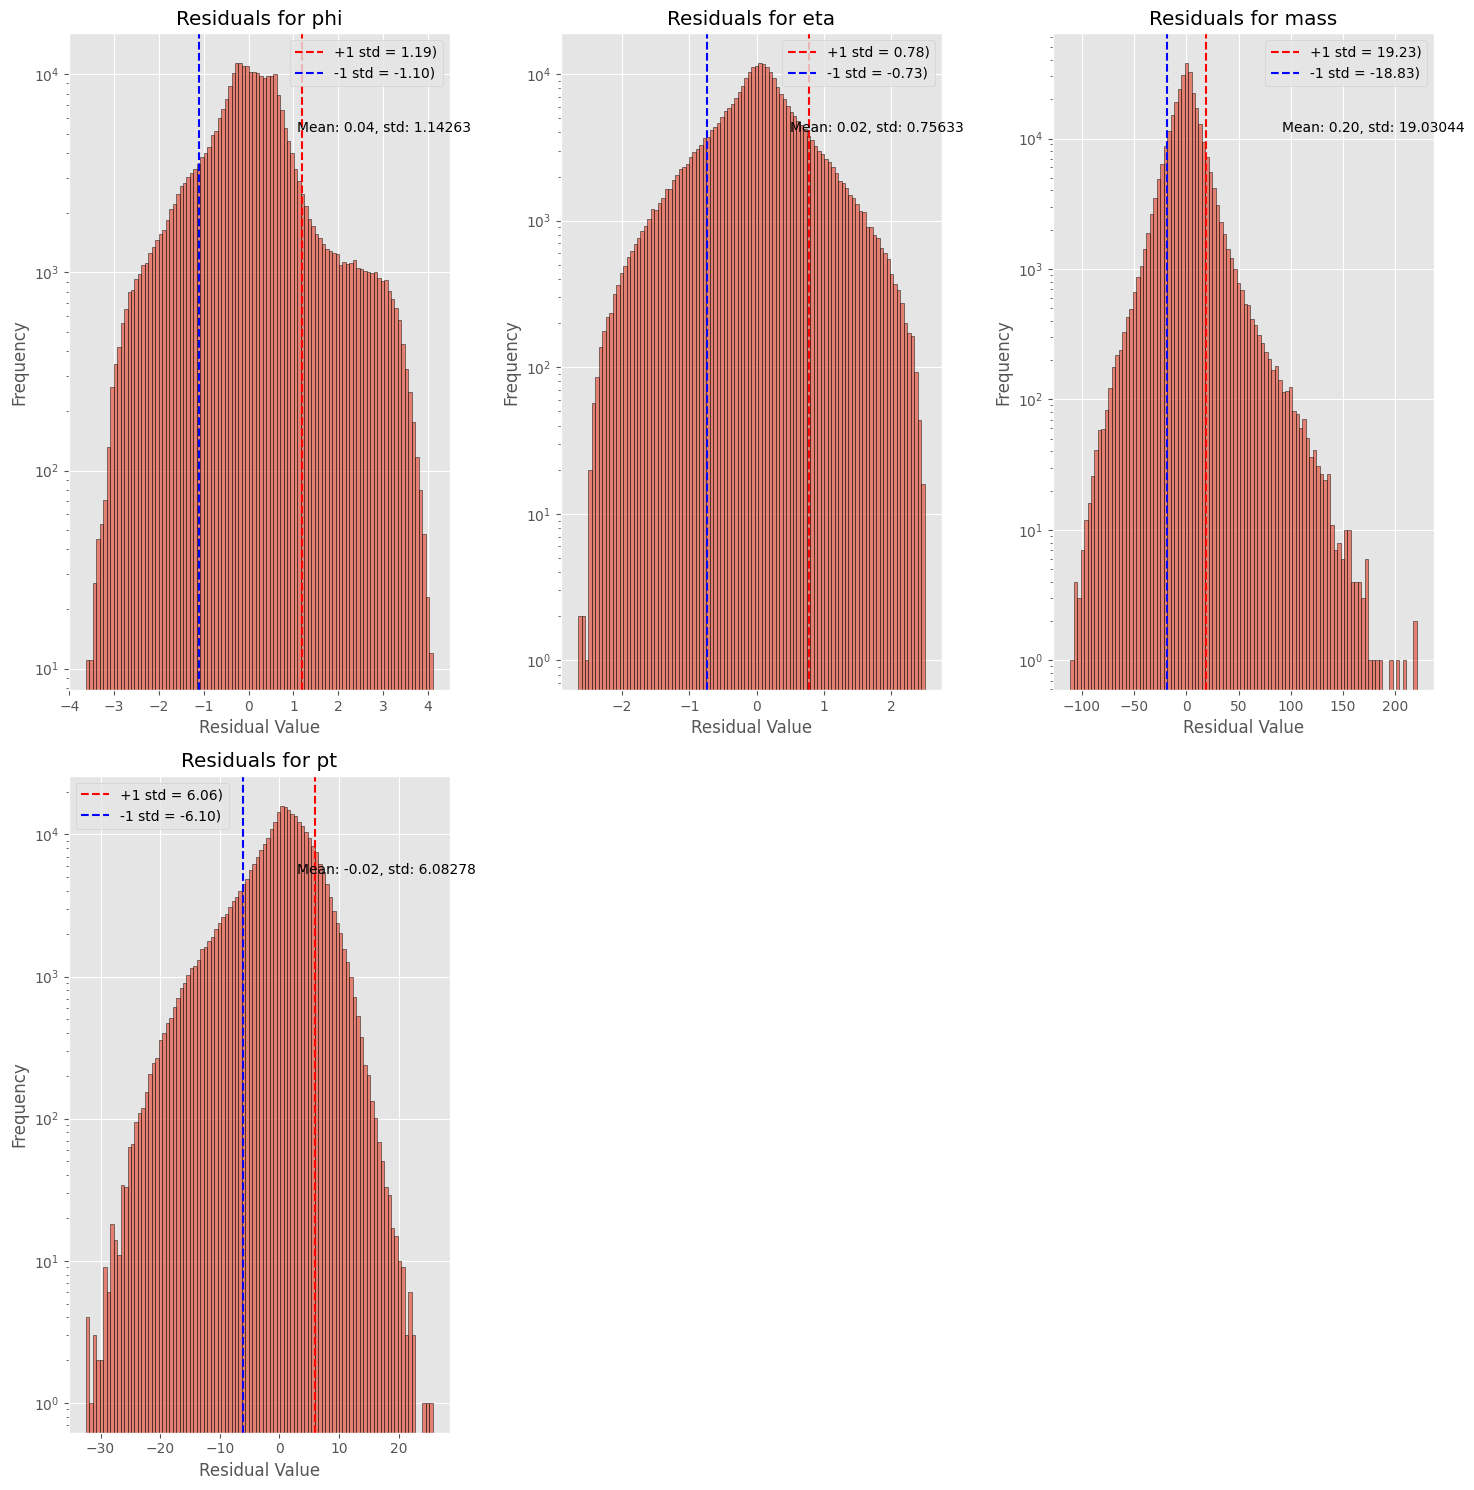

In [45]:
# out_feats=['px', 'py', 'pz', 'energy']
out_feats=['phi', 'eta', 'mass', 'pt']

residuals=np.array([])
y_total=np.array([])
y_pred_total=np.array([])
for i, (x,y) in enumerate(test_loader):
    x = x.to(device)
    y = y.to(device)
    y_pred = model(x)
    y_pred_total=np.append(y_pred_total, y_pred.cpu().detach().numpy())
    y_total=np.append(y_total, y.cpu().detach().numpy())


    # residuals=np.append(residuals, y_pred.cpu().detach().numpy() - y.cpu().detach().numpy())

    # residuals.append(y_pred.cpu().detach().numpy() - y.cpu().detach().numpy())


numfeatures=len(out_feats)
y_pred_total = y_pred_total.reshape(-1,numfeatures)
y_total = y_total.reshape(-1,numfeatures)

print(y_pred_total.shape)
print(y_total.shape)

residuals = [[] for _ in range(numfeatures)]
label_values = [[] for _ in range(numfeatures)]

for i in range(numfeatures):
    y_curr=y_total[:,i]
    # print("ycurr shape before reshape", y_curr.shape)
    
    # print("ycurr shape after reshape", y_curr.shape)
    y_pred_curr=y_pred_total[:,i]
    # y_pred_curr=y_pred_curr.reshape(-1,1)
    # print("ypredcurr shape after reshape", y_pred_curr.shape)
    residuals_curr = y_pred_curr - y_curr
    residuals[i]=residuals_curr
    label_values[i]=y_curr

residuals = [np.array(res_list) for res_list in residuals]  # Convert lists of arrays to arrays
# residual_medians = [np.median(res) for res in residuals]
residual_std_devs = [np.std(res) for res in residuals]
residual_means = [np.mean(res) for res in residuals]


num_rows = numfeatures // 3 + 1
num_cols = 3


fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 15))
flat_axes = axes.flatten()

for i, ax in enumerate(flat_axes[:numfeatures]):
    ax.hist(residuals[i], bins=100, edgecolor='k', alpha=0.65)
    ax.axvline(x=residual_means[i] + residual_std_devs[i], color='r', linestyle='--', label=f'+1 std = {residual_means[i] + residual_std_devs[i]:.2f})')
    ax.axvline(x=residual_means[i] - residual_std_devs[i], color='b', linestyle='--', label=f'-1 std = {residual_means[i] - residual_std_devs[i]:.2f})')
    ax.set_title(f'Residuals for {out_feats[i]}')
    ax.set_yscale('log')
    ax.set_xlabel('Residual Value')
    ax.set_ylabel('Frequency')
    ax.legend()
    
    # Display the mean value on the plot
    mean_text = f"Mean: {residual_means[i]:.2f}, std: {residual_std_devs[i]:.5f}"
    ax.text(0.6, 0.85, mean_text, transform=ax.transAxes)
    

for ax in flat_axes[numfeatures:]:
    ax.axis('off')

plt.tight_layout()
plt.show()
    
    


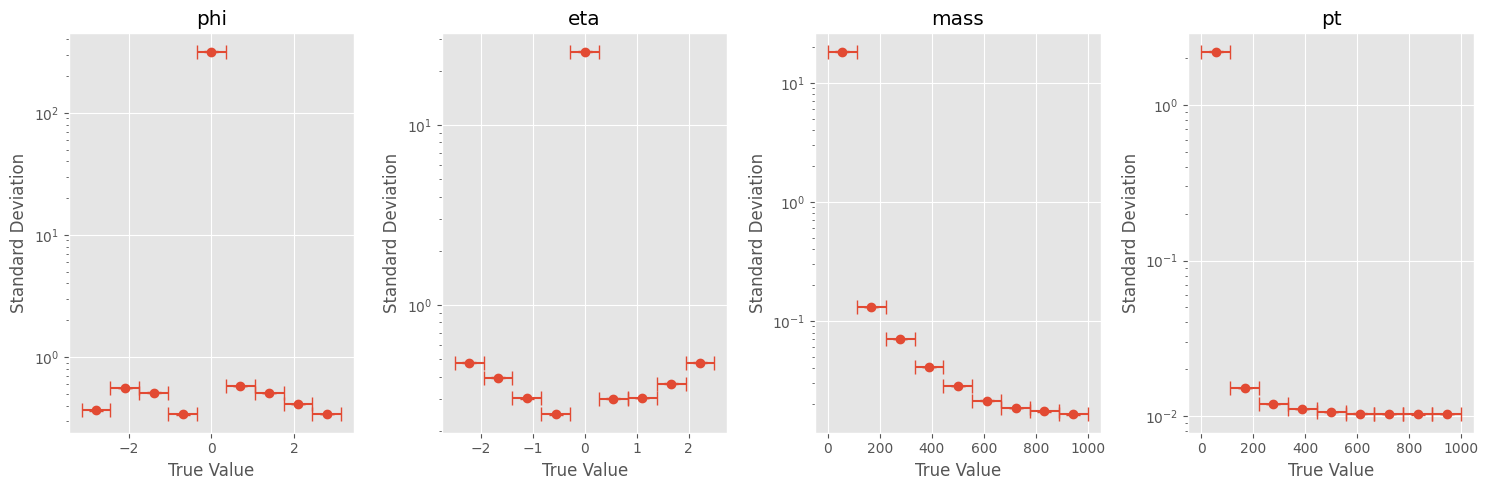

In [46]:
# selected_features = ['phi', 'eta', 'mass', 'pt']
selected_features = ['phi', 'eta', 'mass', 'pt']
selected_indices= range(4)
# selected_indices = [out_feats.index(feat) for feat in selected_features]

# Calculate relative residuals
relative_residuals = [residuals[i] / label_values[i] for i in selected_indices]

# Define logarithmic bins for each feature
# bins = [np.logspace(np.log10(min(label_values[i])), np.log10(max(label_values[i])), num=numbins) for i in selected_indices]

bins=[1,5,10,20,40,60,100,150,200,300,500,750,1000]



# problematic_features = ['px', 'py', 'pz']

# for feature in problematic_features:
#     index = selected_features.index(feature)
#     feature_label_values = np.abs(label_values[selected_indices[index]])  # Take absolute value
#     bins[index] = np.logspace(np.log10(min(feature_label_values)),
#                               np.log10(max(feature_label_values)),
#                               num=10)



# Now, print the new bins for these problematic features
# problematic_bins = {feature: bins[selected_features.index(feature)] for feature in problematic_features}
# problematic_bins



# Adjusting label_values and relative_residuals based on the requirements

# filtered_label_values = []
# filtered_relative_residuals = []

# for idx, feature in enumerate(selected_features):
#     feature_index = selected_indices[idx]


#     feature_label_values = np.abs(label_values[selected_indices[idx]])
#     bins=np.linspace(min(feature_label_values),max(feature_label_values),num=10)
#     # bins=np.logspace(np.log10(min(feature_label_values)),np.log10(max(feature_label_values)),num=10)
#     # print(bins)
    
#     # Mask for px, py, pz
#     # if feature in ['px', 'py', 'pz']:
#     #     mask = (label_values[feature_index] > 1) | (label_values[feature_index] < -1)
#     # # Mask for other features
#     # else:
#     #     mask = label_values[feature_index] > 1

#     filtered_label_values.append(label_values[feature_index][mask])
#     filtered_relative_residuals.append(relative_residuals[idx][mask])

fig, axes = plt.subplots(nrows=1, ncols=len(selected_features), figsize=(15, 5))

for idx, ax in enumerate(axes):

    feature_label_values = label_values[selected_indices[idx]]
    bins=np.linspace(min(feature_label_values),max(feature_label_values),num=10)
    
    # Compute binned statistics (standard deviation)
    bin_stds, bin_edges, binnumber = stats.binned_statistic(label_values[idx],
                                                            relative_residuals[idx],
                                                            statistic='std',
                                                            bins=bins)

    # Compute the uncertainty in standard deviation
    bin_counts, _, _ = stats.binned_statistic(label_values[idx],
                                              relative_residuals[idx],
                                              statistic='count',
                                              bins=bins)
    bin_std_uncertainties = bin_stds / np.sqrt(2 * (bin_counts - 1))

    # Midpoints of the bins
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
    x_errors = np.diff(bin_edges) / 2

    # Scatter plot with error bars
    ax.errorbar(bin_midpoints, bin_stds, xerr=x_errors, yerr=bin_std_uncertainties, fmt='o', capsize=5)
    
    # ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(f'{selected_features[idx]}')
    ax.set_xlabel('True Value')
    ax.set_ylabel('Standard Deviation')

plt.tight_layout()
plt.show()


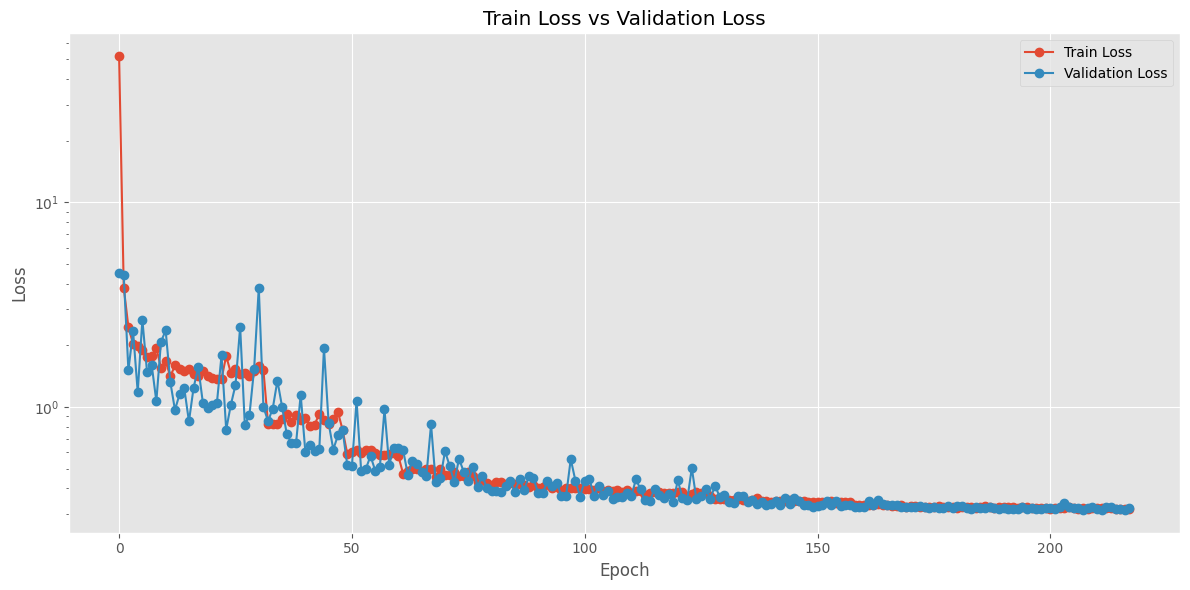

In [47]:
import matplotlib.pyplot as plt

df=pd.read_csv(dfpath)

plt.figure(figsize=(12, 6))
plt.style.use('ggplot')

# Plot train_loss and val_loss
plt.plot(df.index, df['train_loss'], label='Train Loss', marker='o', linestyle='-')
plt.plot(df.index, df['val_loss'], label='Validation Loss', marker='o', linestyle='-')

# Set the title and labels
plt.title('Train Loss vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()


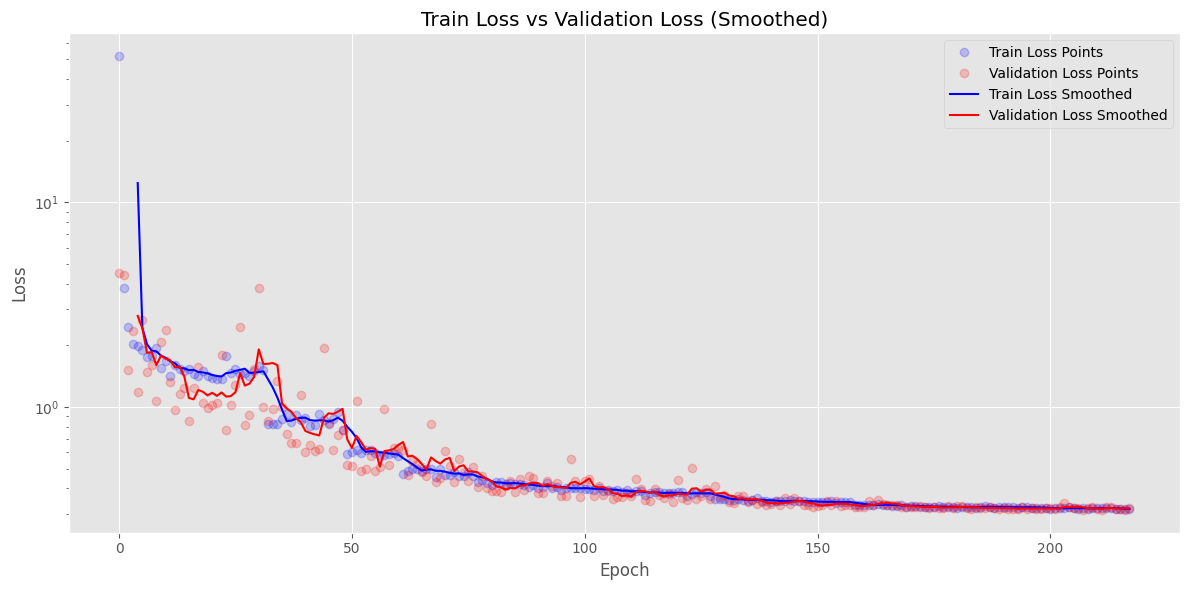

In [48]:
# Define a function to compute moving average
def moving_average(data, window_size):
    return data.rolling(window=window_size).mean()

# Window size for the moving average
window_size = 5  # you can adjust this value as needed

# Compute moving averages
train_loss_smoothed = moving_average(df['train_loss'], window_size)
val_loss_smoothed = moving_average(df['val_loss'], window_size)

# Plotting
plt.figure(figsize=(12, 6))
plt.style.use('ggplot')

# Plot original data points
plt.plot(df.index, df['train_loss'], 'o', label='Train Loss Points', alpha=0.2, color='blue')
plt.plot(df.index, df['val_loss'], 'o', label='Validation Loss Points', alpha=0.2, color='red')

# Plot smoothed lines
plt.plot(df.index, train_loss_smoothed, label='Train Loss Smoothed', linestyle='-', color='blue')
plt.plot(df.index, val_loss_smoothed, label='Validation Loss Smoothed', linestyle='-', color='red')

# Set the title and labels
plt.title('Train Loss vs Validation Loss (Smoothed)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()


KeyError: 'px_rmse'

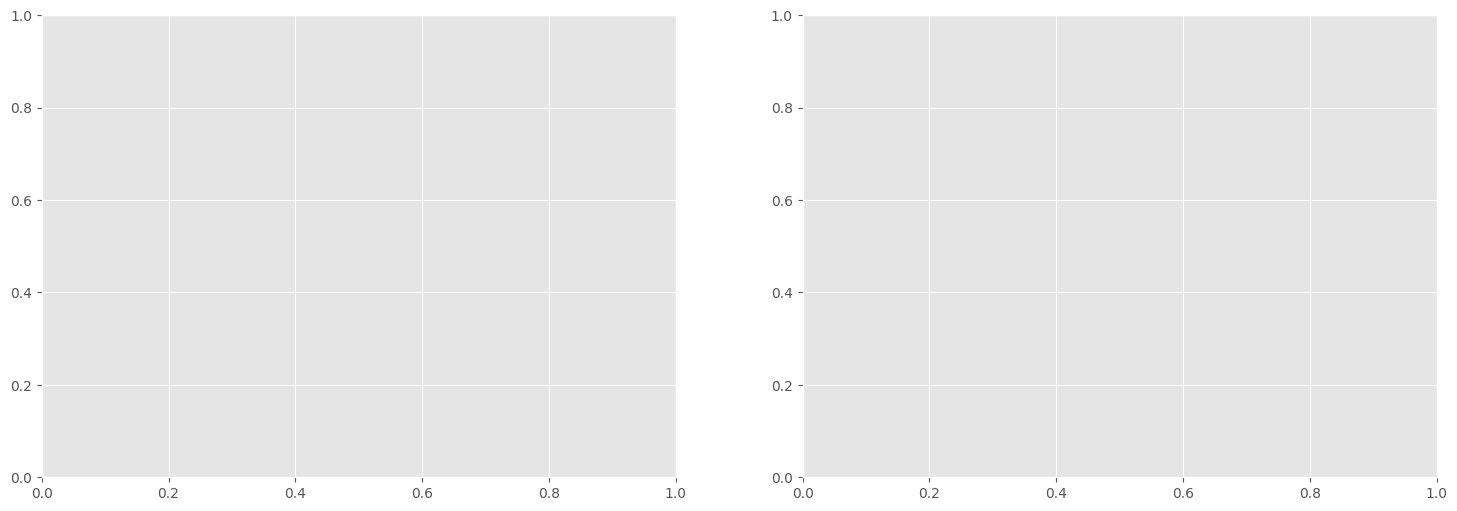

In [49]:
# Set the figure size and create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot RMSE values for px, py, and pz on the first subplot
ax1.plot(df.index, df['px_rmse'], label='px RMSE', marker='o', linestyle='-')
ax1.plot(df.index, df['py_rmse'], label='py RMSE', marker='o', linestyle='-')
ax1.plot(df.index, df['pz_rmse'], label='pz RMSE', marker='o', linestyle='-')
ax1.set_title('RMSE values for px, py, and pz')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('RMSE Value')
ax1.set_yscale('log')
ax1.legend()
ax1.grid(True)

# Plot MSE values for px, py, and pz on the second subplot
ax2.plot(df.index, df['px_mse'], label='px MSE', marker='o', linestyle='-')
ax2.plot(df.index, df['py_mse'], label='py MSE', marker='o', linestyle='-')
ax2.plot(df.index, df['pz_mse'], label='pz MSE', marker='o', linestyle='-')
ax2.set_title('MSE values for px, py, and pz')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('MSE Value')
ax2.legend()
ax2.set_yscale('log')
ax2.grid(True)

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()


In [ ]:
# Compute moving averages for RMSE and MSE values
px_rmse_smoothed = moving_average(df['px_rmse'], window_size)
py_rmse_smoothed = moving_average(df['py_rmse'], window_size)
pz_rmse_smoothed = moving_average(df['pz_rmse'], window_size)

px_mse_smoothed = moving_average(df['px_mse'], window_size)
py_mse_smoothed = moving_average(df['py_mse'], window_size)
pz_mse_smoothed = moving_average(df['pz_mse'], window_size)

# Set the figure size and create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot RMSE values for px, py, and pz on the first subplot
# ax1.plot(df.index, df['px_rmse'], 'o', label='px RMSE Points', alpha=0.5)
# ax1.plot(df.index, df['py_rmse'], 'o', label='py RMSE Points', alpha=0.5)
# ax1.plot(df.index, df['pz_rmse'], 'o', label='pz RMSE Points', alpha=0.5)
ax1.plot(df.index, px_rmse_smoothed, label='px RMSE Smoothed', linestyle='-', color='green')
ax1.plot(df.index, py_rmse_smoothed, label='py RMSE Smoothed', linestyle='-', color='orange')
ax1.plot(df.index, pz_rmse_smoothed, label='pz RMSE Smoothed', linestyle='-', color='purple')
ax1.set_title('RMSE values for px, py, and pz')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('RMSE Value')
ax1.set_yscale('log')
ax1.legend()
ax1.grid(True)

# Plot MSE values for px, py, and pz on the second subplot
# ax2.plot(df.index, df['px_mse'], 'o', label='px MSE Points', alpha=0.5)
# ax2.plot(df.index, df['py_mse'], 'o', label='py MSE Points', alpha=0.5)
# ax2.plot(df.index, df['pz_mse'], 'o', label='pz MSE Points', alpha=0.5)

ax2.plot(df.index, px_mse_smoothed, label='px MSE Smoothed', linestyle='-', color='green')
ax2.plot(df.index, py_mse_smoothed, label='py MSE Smoothed', linestyle='-', color='orange')
ax2.plot(df.index, pz_mse_smoothed, label='pz MSE Smoothed', linestyle='-', color='purple')
ax2.set_title('MSE values for px, py, and pz')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('MSE Value')
ax2.legend()
ax2.set_yscale('log')
ax2.grid(True)



KeyError: 'px_rmse'

In [ ]:
from scipy.stats import pearsonr

out_feats=['px', 'py', 'pz', 'energy']

y_total = {feat: [] for feat in out_feats}
y_pred_total = {feat: [] for feat in out_feats}

for i, (x, y) in enumerate(test_loader):
    x = x.to(device)
    y = y.to(device)
    y_pred = model(x)

    for i, feat in enumerate(out_feats):
        y_pred_total[feat].extend(y_pred[:, i].cpu().detach().numpy())
        y_total[feat].extend(y[:, i].cpu().detach().numpy())

correlations = {}

for feat in out_feats:
    r_value, _ = pearsonr(y_total[feat], y_pred_total[feat])
    correlations[feat] = r_value

print(correlations)


{'px': -0.0015343656007896223, 'py': -8.041538539808424e-06, 'pz': 0.562644179068464, 'energy': 0.7798241895827039}
